In [1]:
from pyspark.sql import SparkSession, functions as F, DataFrame
from pyspark.ml.feature import StringIndexer, VectorAssembler, Imputer, VectorIndexer, Bucketizer, OneHotEncoderEstimator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
spark = SparkSession.builder.getOrCreate()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PATH = '/files'
sdf_train = spark.read.csv(f'{PATH}/train.csv', inferSchema=True, header=True)
# 1460 rows × 81 columns

sdf_test = spark.read.csv(f'{PATH}/test.csv', inferSchema=True, header=True)
# 1459 rows × 80 columns

sdf_sample_submission = spark.read.csv(f'{PATH}/sample_submission.csv', 
                                       inferSchema=True, header=True)
col_sample_submission = ['Id','SalePrice']
# sdf_sample_submission.toPandas()
#dropping below cols as they are having mmore n. of categorical values
drop_cols=['LotFrontage','MasVnrArea','GarageYrBlt']
sdf_train= sdf_train.drop(*drop_cols)
sdf_test= sdf_test.drop(*drop_cols)

In [3]:
pdf = sdf_train.toPandas() # limit(5).
sdf_train.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-- Exterior2nd: string (nullable = true)
 |--

<AxesSubplot:>

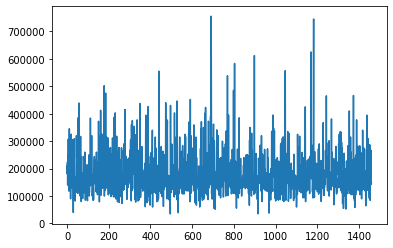

In [4]:
pdf['SalePrice'].plot.line()

<AxesSubplot:xlabel='SaleType'>

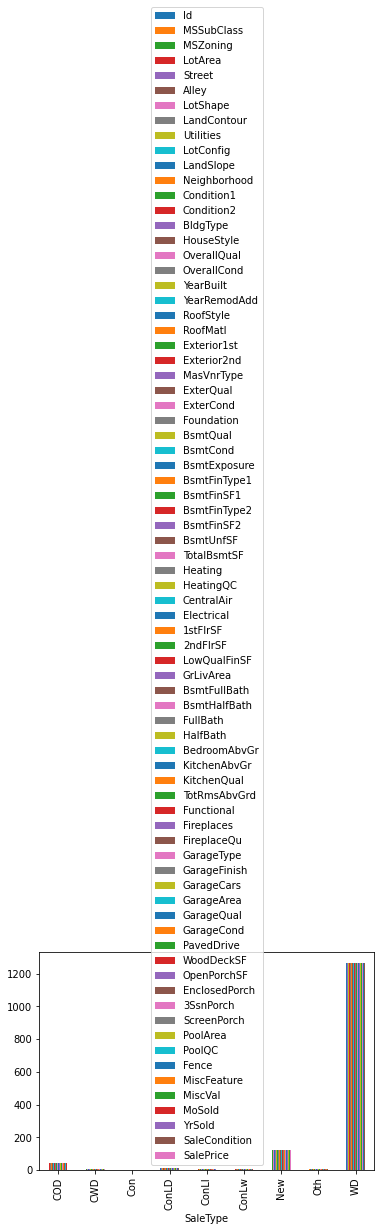

In [5]:
pdf.groupby('SaleType').count().plot.bar()

In [6]:
str_features = [] 
int_features = []
for col in  sdf_train.dtypes:
    if col[1] == 'string':
        str_features += [col[0]]
    else:
        int_features += [col[0]]
#     print(col)
print(f'str_features : {str_features}')
print(f'int_features: {int_features}')
# print(features)
sdf_train_filter = sdf_train.select(int_features + str_features)
int_features.remove('SalePrice')
sdf_test_filter = sdf_test.select(int_features + str_features)

str_features : ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
int_features: ['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',

In [7]:
def _cast_to_int(_sdf: DataFrame,col_list: list) -> DataFrame:
    for col in col_list:
        _sdf = _sdf.withColumn(col, _sdf[col].cast('int'))
    return _sdf

sdf_test_typecast = _cast_to_int(sdf_test_filter, 
                                int_features)

In [8]:
_stages = []
# Imputer not needed as no missing features
# null_impute = Imputer(inputCols= int_features, outputCols=int_features) 
# _stages += [null_impute]

str_indexer = [StringIndexer(inputCol=column,
                           outputCol=f'{column}_StringIndexer',
                            handleInvalid='keep') 
               for column in str_features]
_stages += str_indexer

assembler_input = [f for f in int_features] 
assembler_input += [f'{column}_StringIndexer' 
                    for column  in str_features] 
feature_vector = VectorAssembler(inputCols=assembler_input, 
                                 outputCol='features', 
                                 handleInvalid = 'keep' )
_stages += [feature_vector]


vect_indexer = VectorIndexer(inputCol='features', 
                             outputCol= 'features_indexed', 
                             handleInvalid = 'keep' )
_stages += [vect_indexer]

In [9]:
RFR = RandomForestRegressor(featuresCol='features_indexed', labelCol='SalePrice', ) #0.18353
_stages += [RFR]

In [10]:
ml_pipeline = Pipeline(stages=_stages)
model = ml_pipeline.fit(sdf_train_filter)

In [11]:
sdf_predict = model.transform(sdf_test_typecast)

In [12]:
sdf_predict.withColumnRenamed('prediction','SalePrice').select('Id','SalePrice').toPandas()

,Id,SalePrice
0,1461,126364.433239
1,1462,143012.250096
2,1463,169824.219133
3,1464,184514.678276
4,1465,217025.398607
...,...,...
1454,2915,95279.889441
1455,2916,97910.071567
1456,2917,149076.819000
1457,2918,124903.499037


In [14]:
model.

"cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)\ncheckpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)\nfeatureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)

In [16]:
sdf_train_filter.toJSON().first()

'{"Id":1,"MSSubClass":60,"LotArea":8450,"OverallQual":7,"OverallCond":5,"YearBuilt":2003,"YearRemodAdd":2003,"BsmtFinSF1":706,"BsmtFinSF2":0,"BsmtUnfSF":150,"TotalBsmtSF":856,"1stFlrSF":856,"2ndFlrSF":854,"LowQualFinSF":0,"GrLivArea":1710,"BsmtFullBath":1,"BsmtHalfBath":0,"FullBath":2,"HalfBath":1,"BedroomAbvGr":3,"KitchenAbvGr":1,"TotRmsAbvGrd":8,"Fireplaces":0,"GarageCars":2,"GarageArea":548,"WoodDeckSF":0,"OpenPorchSF":61,"EnclosedPorch":0,"3SsnPorch":0,"ScreenPorch":0,"PoolArea":0,"MiscVal":0,"MoSold":2,"YrSold":2008,"SalePrice":208500,"MSZoning":"RL","Street":"Pave","Alley":"NA","LotShape":"Reg","LandContour":"Lvl","Utilities":"AllPub","LotConfig":"Inside","LandSlope":"Gtl","Neighborhood":"CollgCr","Condition1":"Norm","Condition2":"Norm","BldgType":"1Fam","HouseStyle":"2Story","RoofStyle":"Gable","RoofMatl":"CompShg","Exterior1st":"VinylSd","Exterior2nd":"VinylSd","MasVnrType":"BrkFace","ExterQual":"Gd","ExterCond":"TA","Foundation":"PConc","BsmtQual":"Gd","BsmtCond":"TA","BsmtExp

In [ ]:
SparkContext